In [10]:
import copy
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from collections import defaultdict

In [11]:
#求解Pn~Pm
QN = 3
QM = 0
#求解Rn~Rm
RN = 40

def generate_equidistant_array(min_val, max_val, m):
    if m <= 1:
        return [min_val] * m
    
    step = (max_val - min_val) / (m - 1)
    equidistant_array = [min_val + i * step for i in range(m)]
    
    return equidistant_array

# 定价空间计算
# 空间离散数量
m = 20
D_SPACE = generate_equidistant_array(0.01, 4, m)
# 罚款空间计算
# 空间离散数量
k = 15
PENALTY_SPACE = generate_equidistant_array(0, 1*(RN), k)
print(D_SPACE)
print(PENALTY_SPACE)

[0.01, 0.22000000000000003, 0.43000000000000005, 0.6400000000000001, 0.8500000000000001, 1.06, 1.2700000000000002, 1.4800000000000002, 1.6900000000000002, 1.9000000000000001, 2.11, 2.32, 2.5300000000000002, 2.74, 2.95, 3.16, 3.37, 3.58, 3.79, 4.0]
[0.0, 2.857142857142857, 5.714285714285714, 8.571428571428571, 11.428571428571429, 14.285714285714286, 17.142857142857142, 20.0, 22.857142857142858, 25.714285714285715, 28.571428571428573, 31.42857142857143, 34.285714285714285, 37.142857142857146, 40.0]


In [12]:
class Agent:
    def __init__(self, alpha=0.2, gamma=0.95, beta=0.00001, action_space=D_SPACE):
        """
        代理类，代表一个企业。
        参数:
            alpha (float): 学习率。
            beta (float): epsilon的消散比率
            gamma (float): 未来奖励的折扣因子。
            action_space (list): 决策空间
        """
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.action_space = action_space    # 策略空间

        # 使用defaultdict以便在遇到新状态时自动添加
        self.q_matrix = defaultdict(lambda: dict((action, 0.0) for action in self.action_space))

    def choose_action(self, state, t):
        """
        根据当前状态和时间步选择行动（价格）/选择是explore还是exploit
        参数:
            state (tuple): 当前状态（双方的价格组合）。
            t (int): 当前时间步。
        返回:
            float: 选择的价格。
        """
        epsilon = np.exp(-self.beta * t)
        if np.random.random() < epsilon:
            # explore：随机选择一个价格
            return np.random.choice(self.action_space)
        else:
            return self.get_optimal_action(state)
        
    def get_optimal_action(self, state):
        """
        根据Q-matrix和当前state选择最优行动
        """
        # 如果状态不在Q表中，defaultdict会自动初始化为全0
        optimal_actions = [
            action for action, value in self.q_matrix[state].items() if value == max(self.q_matrix[state].values())
        ]
        return random.choice(optimal_actions)

    def update_q_table(self, state, action, reward, next_state):
        """
        更新Q表。
        参数:
            state (tuple): 双方上一期的价格。
            action (float): 本期的价格决策。
            reward (float): 本期的奖励。
            next_state (tuple): 本期结束双方的价格。
        """
        state_action_value = copy.deepcopy(self.q_matrix[state][action])
        future_next_state_action_value = self.q_matrix[next_state][self.get_optimal_action(next_state)]
        self.q_matrix[state][action] = (1 - self.alpha) * state_action_value + self.alpha * (
                                        reward + self.gamma * future_next_state_action_value)

In [13]:
def calculate_price(quantities):
    """
    根据产量决策计算价格。
    参数:
    quantities (list): 所有公司的产量。
    返回:
    demands (list): 每个公司的需求列表。
    """
    return 120/(sum(quantities))

def calculate_profit(quantities, c=10, a=10):
    """
    计算每个公司的利润。
    参数:
    quantities (list): 所有公司的产量。
    返回:
    profits (list): 每个公司的利润列表。
    """  
    extra = [a]*len(quantities)
    price = calculate_price(quantities)
    profits = [(price - c) * x + y for x, y in zip(quantities, extra)]
    return profits

def consumer_surplus(quantities):
    """
    根据给定的反需求函数与均衡产量/价格，计算消费者剩余
    """
    # 均衡价格
    P_star = calculate_price(quantities)
    Q_star = sum(quantities)
    # 需求曲线积分（从 0 积分到 Q_star）
    cs_integral, _ = quad(lambda Q: (calculate_price([Q]) - P_star), 1e-8, Q_star)    # 在此处将Q转为一个iterable的list
    return cs_integral

def producer_surplus(quantities, c=10):
    """
    计算生产者剩余，用于计算社会福利
    """
    # 均衡价格
    P_star = calculate_price(quantities)
    Q_star = sum(quantities)
    # 生产者剩余（供给曲线与均衡价格的面积差）
    ps_integral = (P_star - c) * Q_star
    return ps_integral

In [14]:
class Market:
    def __init__(self, pricing_agents):
        self.agents = pricing_agents
        print('厂商数量为：',len(self.agents))

    def simulation(self,end_episode=1500000):
        # 初始化
        agents = self.agents
        decesion_record = []
        price_record = []
        rewards_record = []
        walfare_record = []
        price = 20

        # 开始循环
        for episode in tqdm(range(end_episode)):
            # 决策代理选择产量
            new_quantities = [0,0]
            for i in range(len(agents)):
                agent_action = agents[i].choose_action(price,episode)
                new_quantities[i] = agent_action  # 更新产量
            new_quantities = tuple(new_quantities)

            # 计算市场价格
            new_price = calculate_price(new_quantities)
            # 计算销售利润
            profits = calculate_profit(new_quantities)
            # 计算本期的社会总福利
            CS = consumer_surplus(new_quantities)
            PS = producer_surplus(new_quantities)
            
            # 由于此处无regulator，因此rewards = profits
            rewards = profits
            
            # 定价代理进行学习
            for i in range(len(agents)):
                agents[i].update_q_table(price,   # 双方的价格，即状态
                                        new_quantities[i],  # 自己的价格
                                        rewards[i],
                                        new_price)
                
            # 记录本周期的数据
            decesion_record.append(new_quantities)
            price_record.append(price)
            rewards_record.append(profits)
            walfare_record.append([CS,PS])

            price = new_price
            
        return decesion_record,price_record,rewards_record,walfare_record

In [15]:
def calculate_and_plot_averages(data, plot_name, chunk_size = 1000):
    # 确定数据类型
    is_float = (isinstance(data[0], float) or isinstance(data[0], int))

    # 将数据转换为numpy数组
    if is_float:
        data_array = np.array(data)
    else:
        data_array = np.array(data, dtype=object)
    
    # 计算每1000个元素的平均值
    num_chunks = (len(data) + chunk_size - 1) // chunk_size  # 向上取整
    averages = []

    for i in range(num_chunks):
        chunk = data_array[i * chunk_size:(i + 1) * chunk_size]
        if is_float:
            avg = np.mean(chunk)
        else:
            avg = tuple(np.mean(chunk, axis=0))
        averages.append(avg)
    
    # 绘制折线图
    plt.figure(figsize=(10, 6))
    if is_float:
        plt.plot(averages, linestyle='-')
    else:
        for col in range(len(averages[0])):
            plt.plot([avg[col] for avg in averages], linestyle='-', label=f'Agent {col+1}')
        plt.legend()
        
    plt.ylabel('Average Values')
    plt.xlabel('Episodes (of 1000s)')
    plt.title(plot_name)
    plt.grid(True)
    plt.show()

def plot_avg_walfare(data):
    # 转换为 NumPy 数组便于处理
    data_array = np.array(data)

    # 分别提取 CS 和 PS
    CS_values = data_array[:, 0]
    PS_values = data_array[:, 1]

    # 计算新增列 SW = CS + PS
    SW_values = CS_values + PS_values

    # 每 1000 个周期计算一次平均值
    window_size = 1000
    num_windows = len(CS_values) // window_size

    # 计算每 1000 个周期的平均 CS、PS 和 SW
    CS_avg = [np.mean(CS_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
    PS_avg = [np.mean(PS_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]
    SW_avg = [np.mean(SW_values[i*window_size:(i+1)*window_size]) for i in range(num_windows)]

    # 生成 x 轴对应的区间，表示每 1000 个周期为一组
    x_axis = np.arange(1, num_windows + 1) * 1000

    # 创建图形
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 绘制 CS 和 SW 的折线图（左侧 y 轴）
    ax1.plot(x_axis, CS_avg, label='CS')
    ax1.plot(x_axis, SW_avg, label='SW')
    ax1.set_xlabel('Episodes (of 1000s)')
    ax1.set_ylabel('CS and SW')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    # 创建第二个 y 轴用于绘制 PS 的折线图（右侧 y 轴）
    ax2 = ax1.twinx()
    ax2.plot(x_axis, PS_avg, label='PS',color = 'green')
    ax2.set_ylabel('PS')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    # 添加图例和标签
    plt.title('Average Walfare')
    plt.legend()
    # 显示图像
    plt.show()

In [16]:
agent1 = Agent()
agent2 = Agent()

market = Market([agent1,agent2])
decesion_record,price_record,rewards_record,walfare_record = market.simulation()

厂商数量为： 2


100%|██████████| 1500000/1500000 [07:45<00:00, 3225.04it/s]


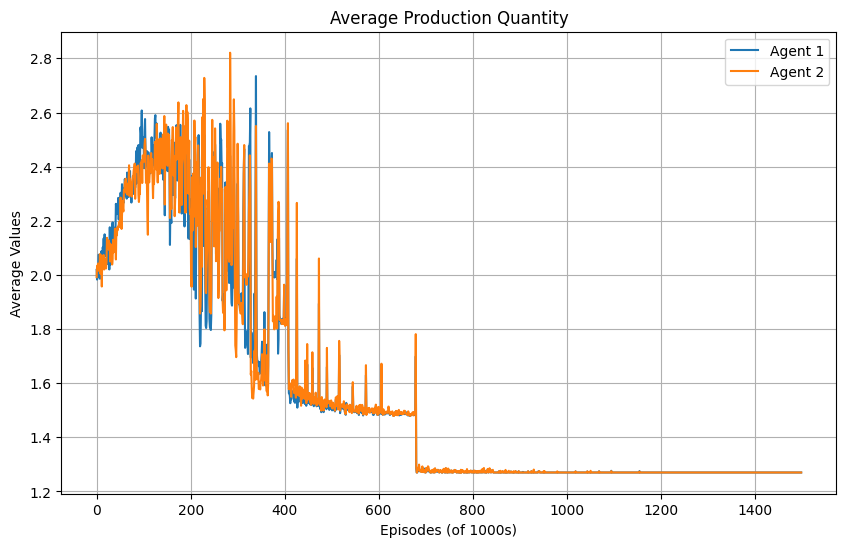

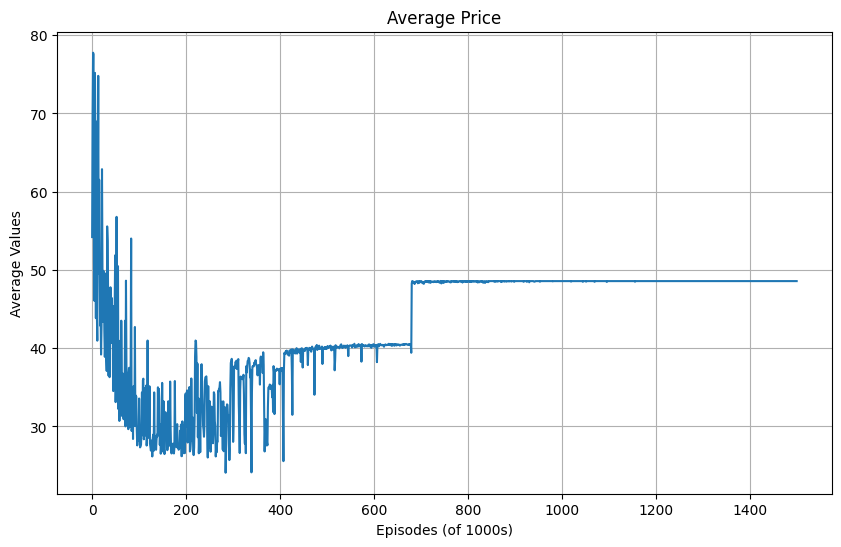

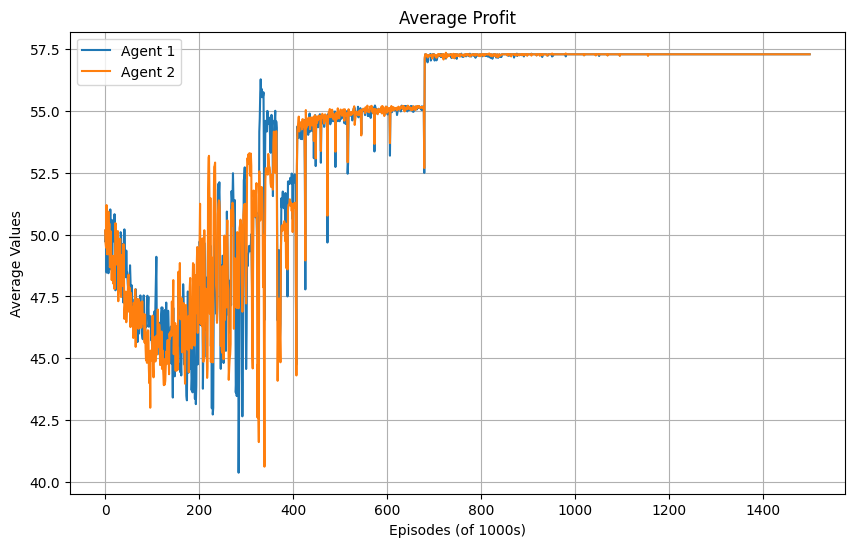

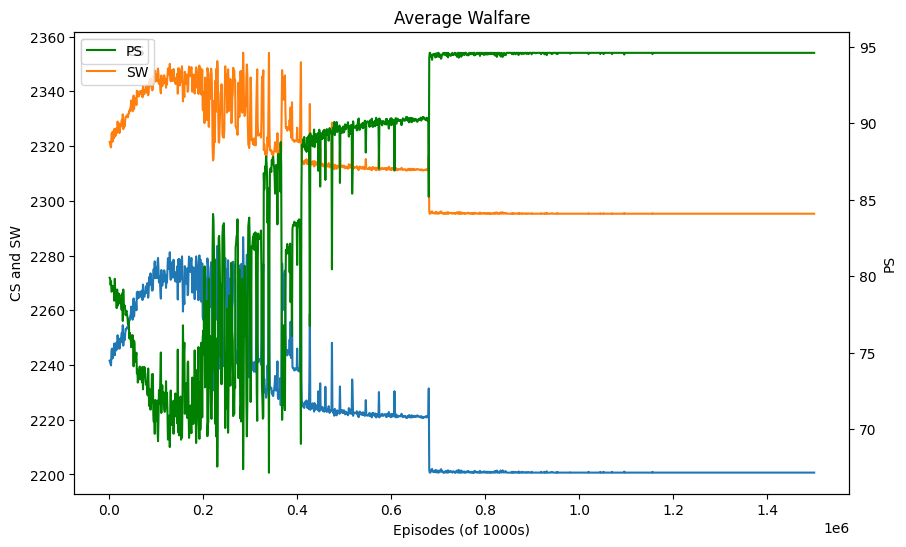

In [17]:
calculate_and_plot_averages(decesion_record,'Average Production Quantity')
calculate_and_plot_averages(price_record,'Average Price')
calculate_and_plot_averages(rewards_record,'Average Profit')
plot_avg_walfare(walfare_record)